<a href="https://colab.research.google.com/github/rexbrahh/Optimization-of-Machine-Learning-Models-for-Prediction-of-Personal-Loan-Default-Rate/blob/main/lightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
import datetime
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold
from sklearn.metrics import (matthews_corrcoef, roc_auc_score,
                             average_precision_score, f1_score)

In [ ]:
tr_public= pd.read_csv("/content/train_public.csv")
tr_internet= pd.read_csv("/content/train_internet.csv")
test = pd.read_csv("/content/test_public.csv")
tr_public.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/train_public.csv'

In [ ]:
tr_public.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   10000 non-null  int64  
 1   user_id                   10000 non-null  int64  
 2   total_loan                10000 non-null  float64
 3   year_of_loan              10000 non-null  int64  
 4   interest                  10000 non-null  float64
 5   monthly_payment           10000 non-null  float64
 6   class                     10000 non-null  object 
 7   employer_type             10000 non-null  object 
 8   industry                  10000 non-null  object 
 9   work_year                 9378 non-null   object 
 10  house_exist               10000 non-null  int64  
 11  censor_status             10000 non-null  int64  
 12  issue_date                10000 non-null  object 
 13  use                       10000 non-null  int64  
 14  post_co

In [ ]:
tr_public.describe()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,9993.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.0,9502.000000,9142.000000,9502.000000,9502.000000,9502.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.025210e+06,225209.587700,14402.126591,3.479600,13.222782,436.960427,0.612200,1.014600,1.762600,257.519100,16.319900,17.532170,0.311600,664.115591,774.448326,11.645000,0.226400,0.138997,16548.299423,53.622625,0.414100,0.020000,1808.20160,1.0,5.690486,0.001422,8.467796,14.659019,8.098085,1.290600,2173.916100,335.232240,0.168300
std,1.438682e+04,14386.820956,8953.946807,0.853965,4.875755,261.754396,0.672203,0.787686,2.392031,201.351778,11.019097,14.218509,0.872457,77.040511,99.174427,5.500745,0.607931,0.379089,21078.544232,26.023562,0.492591,0.140007,8011.09827,0.0,3.298546,0.037685,7.315953,8.263954,4.871797,1.449469,3027.539977,635.108825,0.374151
min,1.000008e+06,200008.000000,818.181818,3.000000,4.779000,30.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,540.000000,585.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.012973e+06,212973.250000,7500.000000,3.000000,9.702000,248.820000,0.000000,0.000000,0.000000,99.000000,8.000000,11.157955,0.000000,601.363636,700.000000,8.000000,0.000000,0.000000,6189.173077,33.969231,0.000000,0.000000,0.00000,1.0,3.000000,0.000000,4.000000,9.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,1.025276e+06,225276.500000,12272.727270,3.000000,12.639000,371.525000,1.000000,1.000000,0.000000,197.000000,14.000000,16.652273,0.000000,665.000000,772.727273,11.000000,0.000000,0.000000,11476.076925,53.280769,0.000000,0.000000,1.00000,1.0,5.000000,0.000000,7.000000,13.000000,7.000000,1.000000,838.500000,0.000000,0.000000
75%,1.037694e+06,237694.500000,19636.363640,3.000000,15.985500,573.830000,1.000000,2.000000,4.000000,390.000000,22.000000,22.781591,0.000000,725.454545,845.000000,14.000000,0.000000,0.000000,20384.076923,73.309615,1.000000,0.000000,5.00000,1.0,7.000000,0.000000,11.000000,19.000000,11.000000,3.000000,3354.250000,413.675000,0.000000
max,1.049997e+06,249997.000000,47272.727270,5.000000,33.979000,1503.890000,4.000000,2.000000,13.000000,901.000000,49.000000,999.000000,15.000000,910.909091,1131.818182,59.000000,12.000000,5.000000,779021.000000,120.615385,1.000000,1.000000,61387.00000,1.0,33.000000,1.000000,93.000000,88.000000,50.000000,5.000000,18413.000000,5523.900000,1.000000


In [ ]:
list(filter(lambda x: x not in list(tr_public.select_dtypes(exclude=['object']).columns),list(tr_public.columns)))

['class',
 'employer_type',
 'industry',
 'work_year',
 'issue_date',
 'earlies_credit_mon']

In [ ]:
tr_public.isna().sum()

loan_id                       0
user_id                       0
total_loan                    0
year_of_loan                  0
interest                      0
monthly_payment               0
class                         0
employer_type                 0
industry                      0
work_year                   622
house_exist                   0
censor_status                 0
issue_date                    0
use                           0
post_code                     0
region                        0
debt_loan_ratio               0
del_in_18month                0
scoring_low                   0
scoring_high                  0
known_outstanding_loan        0
known_dero                    0
pub_dero_bankrup              7
recircle_b                    0
recircle_u                    0
initial_list_status           0
app_type                      0
earlies_credit_mon            0
title                         0
policy_code                   0
f0                          498
f1      

In [ ]:
Employer_type_Dict={"幼教与中小学校":"Ele&Sec_Edu","普通企业":"Normal","政府机构":"Government","上市企业":"Listed","世界五百强":"Top500","高等教育机构":"Adv_Edu"}
Industry_Dict={"金融业":"Finance","电力、热力生产供应业":"Heat&Energy","公共服务、社会组织":"Public_Service","住宿和餐饮业":"Hotel","信息传输、软件和信息技术服务业":"IT","文化和体育业":"Culture&Sports","建筑业":"Constuction","房地产业":"Real_State","采矿业":"Mining","交通运输、仓储和邮政业":"Distribution","农、林、牧、渔业":"Farming","制造业":"Manufacturing","批发和零售业":"Retailing","国际组织":"International"}
Work_Year_Dict={"< 1 year":0,"1 year":1,"2 years":2,"3 years":3,"4 years":4,"5 years":5,"6 years":6,"7 years":7,"8 years":8,"9 years":9,"10+ years":10}
tr_public["employer_type"]=tr_public["employer_type"].map(Employer_type_Dict)
tr_public["industry"]=tr_public["industry"].map(Industry_Dict)
tr_public['work_year']=tr_public['work_year'].map(Work_Year_Dict)

Work_type_Dict={"其他":"Other","职员":"Staff","工人":"Worker","公务员":"Officer","工程师":"Engineer"}
tr_internet['work_type']=tr_internet["work_type"].map(Work_type_Dict)
tr_internet["employer_type"]=tr_internet["employer_type"].map(Employer_type_Dict)
tr_internet["industry"]=tr_internet["industry"].map(Industry_Dict)
tr_internet['work_year']=tr_internet['work_year'].map(Work_Year_Dict)


test["employer_type"]=test["employer_type"].map(Employer_type_Dict)
test["industry"]=test["industry"].map(Industry_Dict)
test['work_year']=test['work_year'].map(Work_Year_Dict)

In [ ]:
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea

numerical_fea = list(tr_public.select_dtypes(exclude=['object']).columns)
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(tr_public,numerical_fea)

print("numerical_serial_fea：",numerical_serial_fea)
print("numerical_noserial_fea：",numerical_noserial_fea)


numerical_serial_fea： ['loan_id', 'user_id', 'total_loan', 'interest', 'monthly_payment', 'work_year', 'use', 'post_code', 'region', 'debt_loan_ratio', 'del_in_18month', 'scoring_low', 'scoring_high', 'known_outstanding_loan', 'known_dero', 'recircle_b', 'recircle_u', 'title', 'f0', 'f2', 'f3', 'f4', 'early_return_amount', 'early_return_amount_3mon']
numerical_noserial_fea： ['year_of_loan', 'house_exist', 'censor_status', 'pub_dero_bankrup', 'initial_list_status', 'app_type', 'policy_code', 'f1', 'early_return', 'isDefault']


In [ ]:
tr_public.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,work_year,house_exist,censor_status,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,9378.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,9993.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.0,9502.000000,9142.000000,9502.000000,9502.000000,9502.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.025210e+06,225209.587700,14402.126591,3.479600,13.222782,436.960427,6.063873,0.612200,1.014600,1.762600,257.519100,16.319900,17.532170,0.311600,664.115591,774.448326,11.645000,0.226400,0.138997,16548.299423,53.622625,0.414100,0.020000,1808.20160,1.0,5.690486,0.001422,8.467796,14.659019,8.098085,1.290600,2173.916100,335.232240,0.168300
std,1.438682e+04,14386.820956,8953.946807,0.853965,4.875755,261.754396,3.686336,0.672203,0.787686,2.392031,201.351778,11.019097,14.218509,0.872457,77.040511,99.174427,5.500745,0.607931,0.379089,21078.544232,26.023562,0.492591,0.140007,8011.09827,0.0,3.298546,0.037685,7.315953,8.263954,4.871797,1.449469,3027.539977,635.108825,0.374151
min,1.000008e+06,200008.000000,818.181818,3.000000,4.779000,30.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,540.000000,585.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,1.005239e+06,205238.900000,4545.454545,3.000000,7.348000,158.122000,1.000000,0.000000,0.000000,0.000000,35.000000,3.000000,6.855818,0.000000,556.363636,649.090909,6.000000,0.000000,0.000000,3172.523077,18.400000,0.000000,0.000000,0.00000,1.0,2.000000,0.000000,2.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000
20%,1.010206e+06,210206.400000,6545.454545,3.000000,8.900000,218.120000,2.000000,0.000000,0.000000,0.000000,74.000000,8.000000,9.840000,0.000000,589.090909,682.500000,7.000000,0.000000,0.000000,5264.830769,29.723077,0.000000,0.000000,0.00000,1.0,3.000000,0.000000,3.000000,8.000000,4.000000,0.000000,0.000000,0.000000,0.000000
30%,1.015425e+06,215424.900000,8369.318182,3.000000,10.341000,273.390000,3.000000,0.000000,0.000000,0.000000,116.000000,8.000000,12.272727,0.000000,609.545455,714.015152,8.000000,0.000000,0.000000,7154.538462,37.907692,0.000000,0.000000,0.00000,1.0,4.000000,0.000000,4.000000,9.000000,5.000000,0.000000,0.000000,0.000000,0.000000
40%,1.020317e+06,220317.200000,10227.272730,3.000000,11.502600,324.516000,5.000000,0.000000,1.000000,0.000000,157.000000,12.000000,14.452727,0.000000,636.363636,742.083333,9.000000,0.000000,0.000000,9178.846154,45.876923,0.000000,0.000000,0.00000,1.0,4.000000,0.000000,5.000000,11.000000,6.000000,0.000000,137.000000,0.000000,0.000000
50%,1.025276e+06,225276.500000,12272.727270,3.000000,12.639000,371.525000,6.000000,1.000000,1.000000,0.000000,197.000000,14.000000,16.652273,0.000000,665.000000,772.727273,11.000000,0.000000,0.000000,11476.076925,53.280769,0.000000,0.000000,1.00000,1.0,5.000000,0.000000,7.000000,13.000000,7.000000,1.000000,838.500000,0.000000,0.000000
60%,1.030049e+06,230049.200000,14890.909090,3.000000,13.959000,445.934000,9.000000,1.000000,1.000000,2.000000,260.000000,18.000000,18.880727,0.000000,685.000000,795.454545,12.000000,0.000000,0.000000,14284.523080,61.500000,1.000000,0.000000,4.00000,1.0,6.000000,0.000000,8.000000,15.000000,8.000000,2.000000,1663.400000,101.040000,0.000000


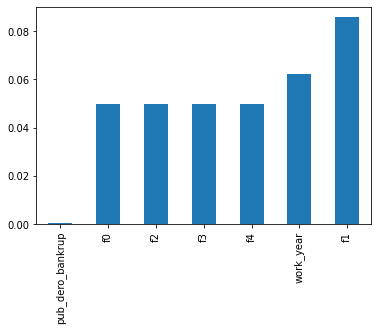

In [ ]:
missing = tr_public.isnull().sum()/len(tr_public)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

## 连续型数值变量
对于连续型变量，可以通过变量的概率密度分布图查看变量的大体分布情况

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

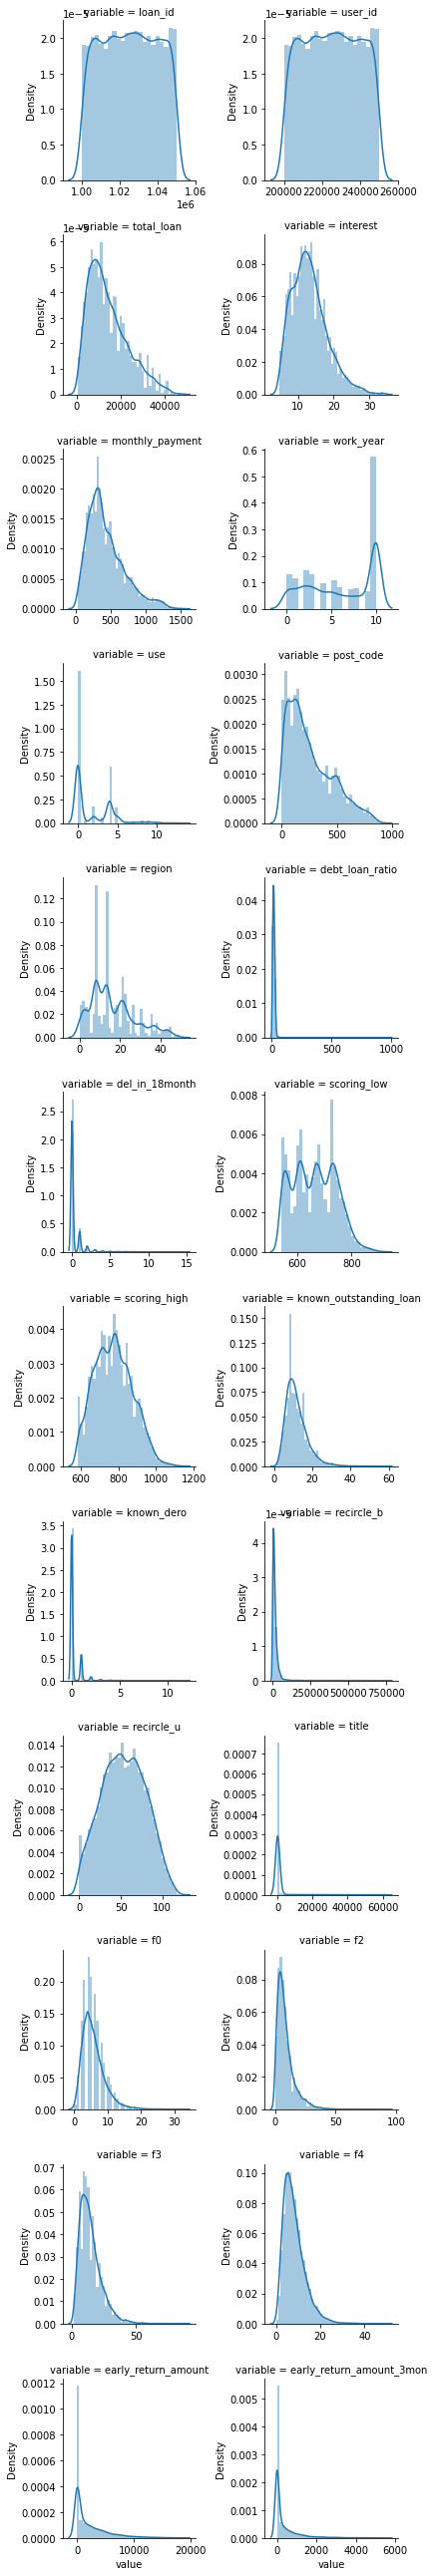

In [ ]:
f = pd.melt(tr_public, value_vars=numerical_serial_fea)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")


In [ ]:
print('Kurtosis: ', tr_public['f0'].kurt())
print('Skewness: ', tr_public['f0'].skew())

Kurtosis:  3.6537092610384065
Skewness:  1.4197122306385666


做这一步的目的是查看某一个数值型变量的分布，观察该变量是否符合正态分布，如果不符合正太分布的变量可以log化后再观察下是否符合正态分布。

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Probability')

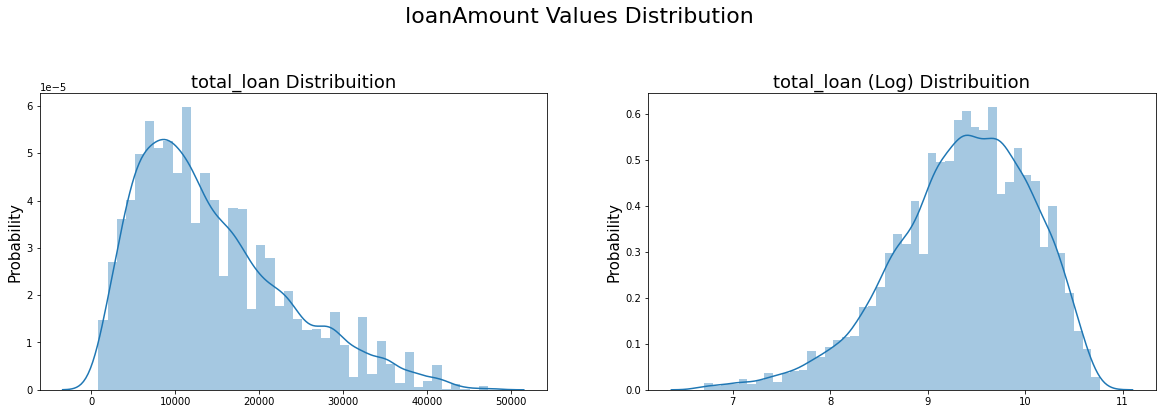

In [ ]:
plt.figure(figsize=(20,12))

plt.suptitle('loanAmount Values Distribution', fontsize=22)
plt.subplot(221)
sub_plot_1 = sns.distplot(tr_public['total_loan'])
sub_plot_1.set_title("total_loan Distribuition", fontsize=18)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(tr_public['total_loan']))
sub_plot_2.set_title("total_loan (Log) Distribuition", fontsize=18)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

用箱线图来查看数据分布集中度

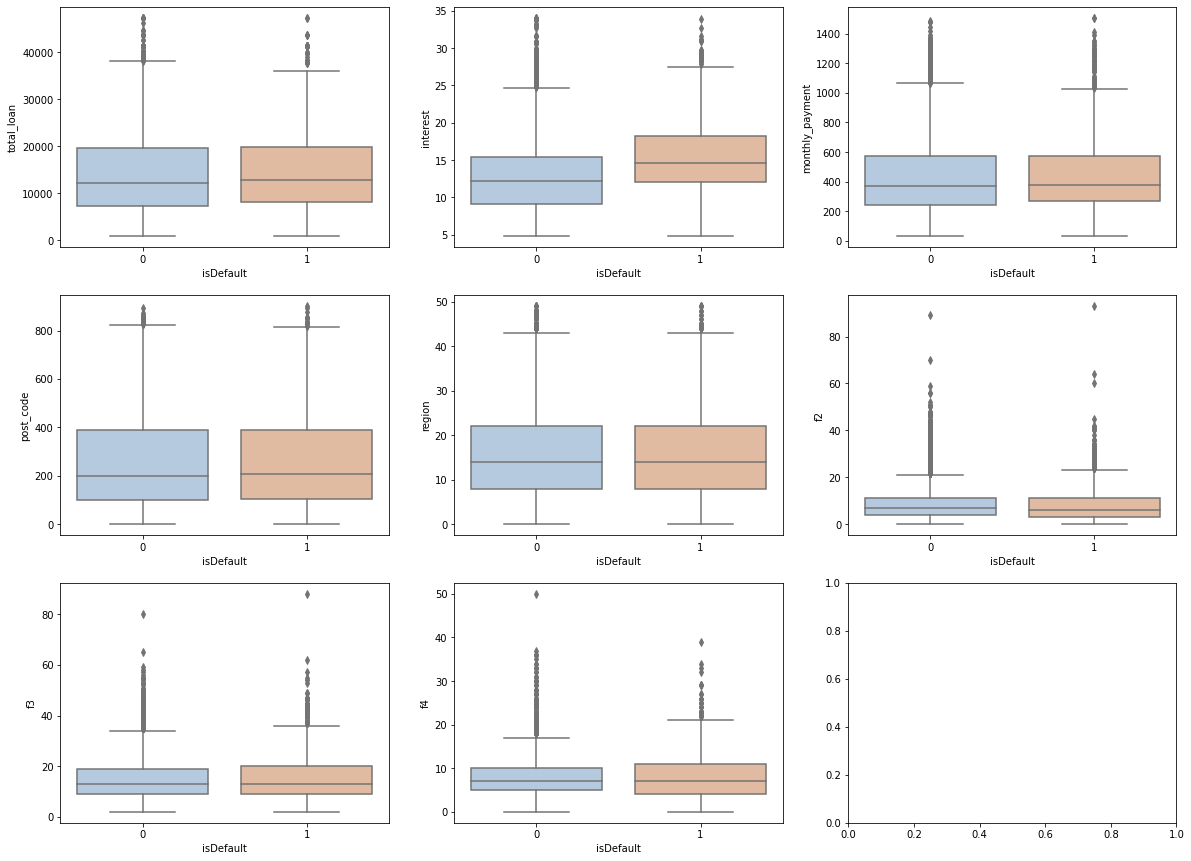

In [ ]:
box_fea = [ 'total_loan', 'interest', 'monthly_payment','post_code', 'region','f2','f3','f4']
f, ax = plt.subplots(3,3, figsize = (20,15))

for i, col in enumerate(box_fea):
    sns.boxplot(x = 'isDefault', y = col, saturation=0.5, palette='pastel', data = tr_public, ax = ax[i//3][i%3])

# 下面在考察目标Y（是否违约欺诈）和单一变量X的统计关系

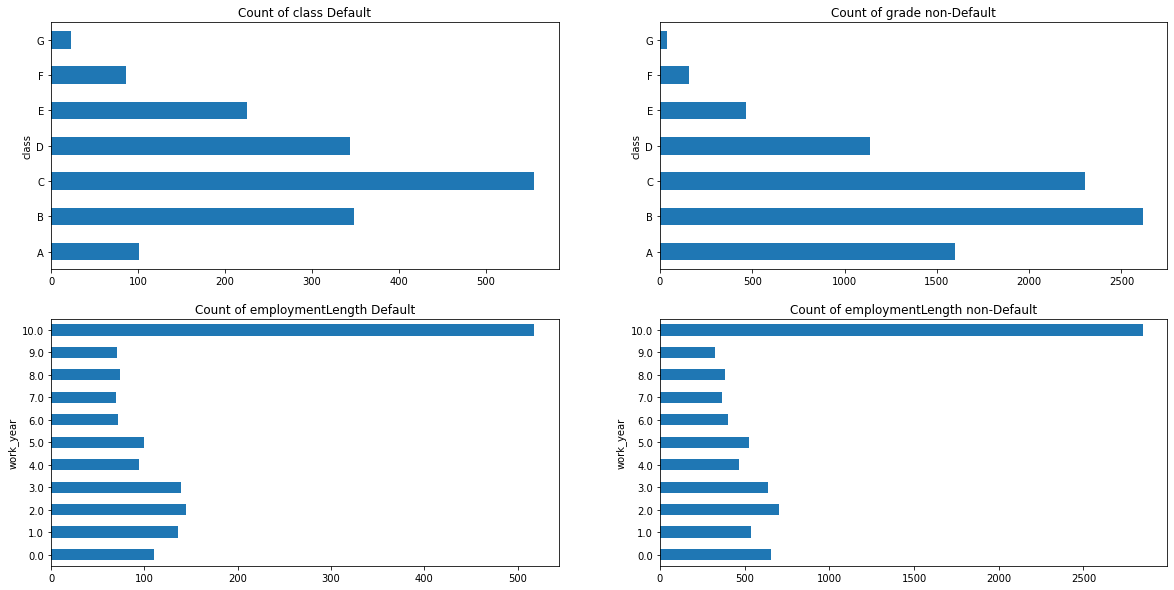

In [ ]:
train_loan_isDefault = tr_public.loc[tr_public['isDefault'] == 1]
train_loan_nonDefault= tr_public.loc[tr_public['isDefault'] == 0]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
train_loan_isDefault.groupby('class')['class'].count().plot(kind='barh', ax=ax1, title='Count of class Default')
train_loan_nonDefault.groupby('class')['class'].count().plot(kind='barh', ax=ax2, title='Count of grade non-Default')
train_loan_isDefault.groupby('work_year')['work_year'].count().plot(kind='barh', ax=ax3, title='Count of employmentLength Default')
train_loan_nonDefault.groupby('work_year')['work_year'].count().plot(kind='barh', ax=ax4, title='Count of employmentLength non-Default')

特征工程：缺省值补充

In [ ]:
numerical_fea = list(tr_public.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(tr_public.columns)))
label = 'isDefault'
numerical_fea.remove(label)
tr_public.isnull().sum()

loan_id                       0
user_id                       0
total_loan                    0
year_of_loan                  0
interest                      0
monthly_payment               0
class                         0
employer_type                 0
industry                      0
work_year                   622
house_exist                   0
censor_status                 0
issue_date                    0
use                           0
post_code                     0
region                        0
debt_loan_ratio               0
del_in_18month                0
scoring_low                   0
scoring_high                  0
known_outstanding_loan        0
known_dero                    0
pub_dero_bankrup              7
recircle_b                    0
recircle_u                    0
initial_list_status           0
app_type                      0
earlies_credit_mon            0
title                         0
policy_code                   0
f0                          498
f1      

In [ ]:
tr_public[numerical_fea] = tr_public[numerical_fea].fillna(tr_public[numerical_fea].median())
test[numerical_fea] = test[numerical_fea].fillna(tr_public[numerical_fea].median())
#按照众数填充类别型特征
tr_public[category_fea] = tr_public[category_fea].fillna(tr_public[category_fea].mode())
test[category_fea] = test[category_fea].fillna(tr_public[category_fea].mode())
tr_public.isnull().sum()

loan_id                     0
user_id                     0
total_loan                  0
year_of_loan                0
interest                    0
monthly_payment             0
class                       0
employer_type               0
industry                    0
work_year                   0
house_exist                 0
censor_status               0
issue_date                  0
use                         0
post_code                   0
region                      0
debt_loan_ratio             0
del_in_18month              0
scoring_low                 0
scoring_high                0
known_outstanding_loan      0
known_dero                  0
pub_dero_bankrup            0
recircle_b                  0
recircle_u                  0
initial_list_status         0
app_type                    0
earlies_credit_mon          0
title                       0
policy_code                 0
f0                          0
f1                          0
f2                          0
f3        

In [ ]:
features = [c for c in tr_public.columns if c not in ['loan_id','user_id','isDefault']]

In [ ]:
tr_internet.isna().sum()

loan_id                        0
user_id                        0
total_loan                     0
year_of_loan                   0
interest                       0
monthly_payment                0
class                          0
sub_class                      0
work_type                      0
employer_type                  0
industry                       0
work_year                   3088
house_exist                    0
house_loan_status              0
censor_status                  0
marriage                       0
offsprings                     0
issue_date                     0
use                            1
post_code                      1
region                         1
debt_loan_ratio               22
del_in_18month                 1
scoring_low                    1
scoring_high                   1
pub_dero_bankrup              26
early_return                   1
early_return_amount            1
early_return_amount_3mon       1
recircle_b                     1
recircle_u

In [ ]:
for data in [tr_public, test]:
    data['issue_date'] = pd.to_datetime(data['issue_date'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issue_date'].apply(lambda x: x-startdate).dt.days

下面直接调用sk-learn下面的preprocessing模块处理：

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
tr_public['class'] = le.fit_transform(tr_public['class'])
tr_public['work_year'] = tr_public['work_year'].apply(lambda x : str(x))
tr_public['work_year'] = le.fit_transform(tr_public['work_year'])
test['class'] = le.fit_transform(test['class'])
test['work_year'] = test['work_year'].apply(lambda x : str(x))
test['work_year'] = le.fit_transform(test['work_year'])


In [ ]:
print([column for column in tr_public])

['loan_id', 'user_id', 'total_loan', 'year_of_loan', 'interest', 'monthly_payment', 'class', 'employer_type', 'industry', 'work_year', 'house_exist', 'censor_status', 'issue_date', 'use', 'post_code', 'region', 'debt_loan_ratio', 'del_in_18month', 'scoring_low', 'scoring_high', 'known_outstanding_loan', 'known_dero', 'pub_dero_bankrup', 'recircle_b', 'recircle_u', 'initial_list_status', 'app_type', 'earlies_credit_mon', 'title', 'policy_code', 'f0', 'f1', 'f2', 'f3', 'f4', 'early_return', 'early_return_amount', 'early_return_amount_3mon', 'isDefault', 'issueDateDT']


## LIGHTGBM

In [ ]:
from sklearn.model_selection import train_test_split
Public_Train,Public_Test=train_test_split(tr_public,test_size=0.25,random_state=42)

In [ ]:
#Selection of independence variables and response variables
Y_Public_Train=Public_Train["isDefault"]
Y_Public_Test=Public_Test["isDefault"]
X_Public_Train=Public_Train.drop(["loan_id","user_id","issue_date","earlies_credit_mon","employer_type","industry"],axis=1)
X_Public_Test=Public_Test.drop(["loan_id","user_id","issue_date","earlies_credit_mon","employer_type","industry"],axis=1)

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
gbm = LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=20)
gbm.fit(X_Public_Train, Y_Public_Train, eval_set=[(X_Public_Test, Y_Public_Test)], eval_metric='l1', early_stopping_rounds=5)

# 模型存储
joblib.dump(gbm, 'loan_model.pkl')
# 模型加载
gbm = joblib.load('loan_model.pkl')

# 模型预测
y_pred = gbm.predict(X_Public_Test, num_iteration=gbm.best_iteration_)

# 模型评估
print('The rmse of prediction is:', mean_squared_error(Y_Public_Test, y_pred) ** 0.5)

# 特征重要度
print('Feature importances:', list(gbm.feature_importances_))

# 网格搜索，参数优化
estimator = LGBMRegressor(num_leaves=31)
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}
gbm = GridSearchCV(estimator, param_grid)
gbm.fit(X_Public_Train, Y_Public_Train)
print('Best parameters found by grid search are:', gbm.best_params_)



[1]	valid_0's l2: 0.123529	valid_0's l1: 0.263992
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.111485	valid_0's l1: 0.250792
[3]	valid_0's l2: 0.100615	valid_0's l1: 0.238253
[4]	valid_0's l2: 0.0908052	valid_0's l1: 0.22634
[5]	valid_0's l2: 0.0819517	valid_0's l1: 0.215023
[6]	valid_0's l2: 0.0739614	valid_0's l1: 0.204272
[7]	valid_0's l2: 0.0667502	valid_0's l1: 0.194058
[8]	valid_0's l2: 0.060242	valid_0's l1: 0.184355
[9]	valid_0's l2: 0.0543684	valid_0's l1: 0.175138
[10]	valid_0's l2: 0.0490675	valid_0's l1: 0.166381
[11]	valid_0's l2: 0.0442834	valid_0's l1: 0.158062
[12]	valid_0's l2: 0.0399658	valid_0's l1: 0.150159
[13]	valid_0's l2: 0.0360691	valid_0's l1: 0.142651
[14]	valid_0's l2: 0.0325524	valid_0's l1: 0.135518
[15]	valid_0's l2: 0.0293785	valid_0's l1: 0.128742
[16]	valid_0's l2: 0.0265141	valid_0's l1: 0.122305
[17]	valid_0's l2: 0.023929	valid_0's l1: 0.11619
[18]	valid_0's l2: 0.0215959	valid_0's l1: 0.11038
[19]	valid_0's l2: 0

In [ ]:
pip install --upgrade scikit-learn